In [1]:
# General Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns

import shap


# My Modules
from wilkeXAI.data_generator import DataGenerator
import wilkeXAI.wilke_shap as fwg
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [2]:
class DataGenerator():
    def __init__(self, features = ['x0','v0','t','rand'], 
                 labels = ['xt','vt'], 
                 x_range=[-2,2], v_range = [-1,1]):
        self.features = features
        self.labels = labels
        self.x_range = x_range
        self.v_range = v_range
    
    def generate(self, num_samples = int(1e3), delay=0, samples=500, end_time=100, 
                 params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        #Initialise the output arrays
        self.params = params
        self.parameter_length = 1
        for key in self.params:
            self.parameter_length  *= len(self.params[key]) 
        self.X = np.empty((num_samples*self.parameter_length, (len(self.features)+len(params))))
        self.y = np.empty((num_samples*self.parameter_length, len(self.labels)))
        complete_feature_vec = self.features.copy()
        for k in params:
            complete_feature_vec.append(k)
        #Define bounds of the sampling
        x_min = self.x_range[0]
        x_max = self.x_range[1]
        v_min = self.v_range[0]
        v_max = self.v_range[1]
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, samples, endpoint=False)
        #Generate num_samples samples
        for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
            ticker = 0
            #Generate random starting positions
            x0 = (x_max - x_min) * np.random.random_sample() + x_min
            v0 = (v_max - v_min) * np.random.random_sample() + v_min
            for alpha in params['alpha']:
                for beta in params['beta']:
                    for gamma in params['gamma']:
                        for delta in params['delta']:
                            for omega in params['omega']:
                                
                                self.current_params = {'alpha' : alpha,'beta' : beta, 'delta' : delta, 
                                                       'gamma' :gamma, 'omega' : omega}
                                #Generate a trajectory
                                trajectory = odeint(self.eom, [x0,v0], t_range)
                                t_ind = samples-10#np.random.randint(samples)
                                self.X[i*self.parameter_length+ticker,:] = [x0, v0, t_range[t_ind], np.random.sample(), alpha, beta, gamma, delta, omega]
                                self.y[i*self.parameter_length+ticker,:] = trajectory[t_ind,:]
                                ticker +=1
                                    
                                    
        
        
        self.X = pd.DataFrame(self.X, columns = complete_feature_vec)
        self.y = pd.DataFrame(self.y, columns = self.labels)
        return self.X, self.y


    def save(self, suffix=None, filepath = "Data/"):
        self.X.to_csv(filepath+"X"+suffix+".csv")
        self.y.to_csv(filepath+"y"+suffix+".csv")
        
    def eom(self, u, t):
        """
            Duffing Oscillator Equation of Motion
    
            ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)
    
            Input
            ----------
            u : vector of length 2, (x,v)
                Position and Velocity at time t
            t : float, the time t
    
            Parameters
            ----------
            alpha : float, linear stiffness
            beta  : float, non linearity in the restoring force
            gamma : float, amplitude of the periodic driving force
            delta : float, amount of damping
            omega : float, angular frequency of the periodic driving force
    
            Returns
            ----------
            [dx,ddx] : Tuple, Time derivatives of 
                        position and velocity at time t
    
        """
        x, dx = u[0], u[1]
        ddx = (self.current_params['gamma'] * np.cos(self.current_params['omega'] * t) - 
               (self.current_params['delta'] * dx + self.current_params['alpha']*x + self.current_params['beta'] * x**3))
    
        return [dx,ddx]

In [3]:
data_parameters = {'alpha' : [-1],'beta' : [1], 'gamma' :[0], 'delta' : [1], 'omega' : [1.2]}
generator = DataGenerator()

X, y = generator.generate(num_samples=int(1e4), params = data_parameters, delay=400)

Generating Data…: 100%|█████████████| 10000/10000 [00:27<00:00, 365.90it/s]


In [11]:
X.loc[:,('alpha','beta','gamma','delta','omega')]

,alpha,beta,gamma,delta,omega
0,-1.0,1.0,0.0,1.0,1.2
1,-1.0,1.0,0.0,1.0,1.2
2,-1.0,1.0,0.0,1.0,1.2
3,-1.0,1.0,0.0,1.0,1.2
4,-1.0,1.0,0.0,1.0,1.2
...,...,...,...,...,...
9995,-1.0,1.0,0.0,1.0,1.2
9996,-1.0,1.0,0.0,1.0,1.2
9997,-1.0,1.0,0.0,1.0,1.2
9998,-1.0,1.0,0.0,1.0,1.2


In [189]:
class TrueModel():
    """
    Class to represent the True Model of the Duffing oscillator.
    Uses the scipy odeint integrator to perform time evolution.
    """
    def __init__(self, scaler, X):
        """
            Intialise Model

            Inputs
            --------
            scaler : sklearn.preprocessing.Standardscaler object that has already been trained
            X : pd.DataFrame with columns giving the features
        """
        self.scaler = scaler
        self.cols = X.columns
        
    def eom(self, u, t, params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}):
        """
            Equation of Motion for the Duffing Oscillator

            Inputs
            --------
            u : vector of floats, x, v
            t : float, time t

        """
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X, params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}):
        """
            Calculates the temporal evolution of [X['x0'], X['v0']] to time X['t'].

            Inputs
            --------
            X : pandas DataFrame with at least columns x0,v0,t

            Returns
            --------
            y : pandas.DataFrame with columns xt,vt
        """
        eom = lambda u, t: self.eom(u, t, params = {'alpha' : X['alpha'],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]})
        if type(X) == pd.core.frame.DataFrame:
            X = pd.DataFrame(self.scaler.inverse_transform(X.values), columns=X.columns)
        elif type(X) == np.ndarray:
            X = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.cols)
        #X = pd.DataFrame(self.scaler.inverse_transform(X[:,:3]), columns=['x0','v0','t'])
        y = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            y[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
        #y = pd.DataFrame(y, columns=['xt','vt'])    
        return y

In [ ]:
class wilke_explainer():
    """
        Class to evaluate models and plot both the individual and aggregate 
        feature importance. Implements a method for shap and for lime.
        Implements methods from the SHAP library, tailored for this notebook.
    """
    def __init__(self, models, background_data, test_data, test_labels, suffix = None, data_tol=0.1, num_vals=100, 
                 explainer_type='shap', background_resolution=100, tolerance=0.1):
        """
            Initialises the explainer objects for the various models.
            
            Parameters
            ----------
            models : dictionary of models that implement a predict function
                that take a 2d numpy.array or pandas.DataFrame
                
            background_data : pandas.DataFrame with samples of training data,
                used to create a masker for the explainer objects
                
            test_data : pandas.DataFrame with samples of test data,
                used to choose samples on which to evaluate the explainers.
                
            test_labels : pandas.DataFrame with samples of test labels,
                used to choose good samples on which to evaluate the explainers.

            suffix : str, added to the saving filepath for the plots.
                
            data_tol : float, thickness of band in which data_points are considered 
                to be close to the mean value.
                
            num_vals : int, maximum number of values on which the explainers are
                evaluated.
                
            explainer_type : str, 'shap' or 'lime', decides which explainer is being
                implemented: shap.KernelExplainer or shap.LimeTabular.
                
            background_resolution : int, number of samples of the background_data to
                be used to create the masker for the explainers.
                
            tolerance : float, determines how close a model prediction must be to the
                true value for it to be considered a good estimate.

        """
        self.num_vals = num_vals
        self.tol = data_tol
        self.models = models
        self.background_data = background_data
        self.test_data = test_data
        self.test_labels = test_labels
        self.tolerance = tolerance
        self.explainers = {}
        self.suffix = suffix
        self.background = shap.sample(self.background_data, background_resolution)
        self.explainer_type = explainer_type
        if explainer_type=='shap':
             for mod in models:
                self.explainers[mod] = shap.KernelExplainer((models[mod]).predict, self.background)
                
        elif explainer_type=='lime':
             for mod in models:
                self.explainers[mod] = shap.other.LimeTabular((models[mod]).predict, 
                                                                     self.background, mode="regression")
        elif explainer_type=='analytic':
            for mod in models:
                self.explainers[mod] = AnalyticExplainer(models[mod].predict, test_data.columns, test_labels.columns)
    
    def choose_data(self, feature, i):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((self.models['ml']).predict(self.test_data), axis=1) - 
                      np.linalg.norm(self.test_labels, axis=1))
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr[feature].values, dtype=bool)
        
        for j in range(1,3):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%3])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr 
        
    def eval_explainer(self):
        """
            Evaluates the explainers on data chosen by the choose_data function.
            
            Returns
            ---------
            feature_attributions : pandas.DataFrame, array of the feature attributions
                with a multiindex (index, feature, contribution, model)
        """
        first_run = True
        for i, __feature in enumerate(self.test_data.columns):
            if __feature in ['x0','v0''t']:
                arr = self.choose_data(__feature, i)
            else:
                arr = self.test_data.iloc[np.sort(np.random.choice(self.test_data.shape[0], 
                                                                   self.num_vals, replace=False))]
            for __explainer in self.explainers:
                if self.explainer_type=='shap':
                    __atts = self.explainers[__explainer].shap_values(arr)
                if self.explainer_type=='lime':
                    __atts = self.explainers[__explainer].attributions(arr)
                if self.explainer_type=='analytic':
                    __atts = self.explainers[__explainer].feature_att(arr)
                
                for j, __contribution in enumerate(self.test_labels.columns):
                    multi_index = [range(len(arr)), [__feature for i in range(len(arr))], 
                                   [__contribution for i in range(len(arr))],
                                   [__explainer for i in range(len(arr))]]
                    if first_run:
                        self.feature_attributions = pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model')))
                        first_run = False
                    else:
                        self.feature_attributions = self.feature_attributions.append(pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model'))))
                    
        return self.feature_attributions
        
    def exp_plot(self):
        """
            Plotting routine to visualise the explainers' results. Plots individual
            feature contribution for each model and each feature.
        """
        f, axs = plt.subplots(self.test_labels.shape[1], self.test_data.shape[1], 
                              figsize=(4*self.test_data.shape[1], 8), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_data.shape[1]))))

        for i, __feature in enumerate(self.test_data.columns):
            for j, __contribution in enumerate(self.test_labels.columns):
                for __model in self.models:
                    sns.scatterplot(data = self.feature_attributions.xs((__feature, __contribution, __model), 
                                                      level=('feature', 'contribution', 'model')), 
                                    x = self.feature_attributions.xs((__feature, __contribution, 'true'), 
                                                   level=('feature', 'contribution', 'model')).index,
                                    y = self.feature_attributions.xs((__feature, __contribution, __model), 
                                                 level=('feature', 'contribution', 'model'))[__feature],
                                    label = __model, ax=axs[j,i])  
                    
                axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
                axs[j,i].set_xlabel('Index [ ]')
                axs[j,i].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()

        f.savefig("Images/"+self.explainer_type+"_summary"+self.suffix+"_kernel_good.svg", dpi='figure')
    
    def agg_func(self, X):
        """
            Function by which data aggregation is performed.
        
            Inputs
            -------
            X : numpy.array, array of values for which the aggregation is performed.
                Is a list of the values for a single feature, single contribution
                and single model.
                
            Returns
            -------
            y : value of the aggregation f(X).
        """
        return np.mean(np.abs(X))
    
    def aggregate(self):
        """
            Performs data aggregation. Aggregates for each feature its contribution to
            each output variable for a given model.
            
            Returns
            -------
            agg_vals : pandas.DataFrame, aggregated feature importance.
        """
        first_run = True
        
        for i, __contribution in enumerate(self.test_labels.columns):
            for j, __model in enumerate(self.models):
                for k, __feature in enumerate(self.test_data.columns):
                    
                    multi_index = [[__feature], [__contribution], [__model]]
                    if first_run:
                        self.agg_vals = pd.DataFrame(self.agg_func(
                            self.feature_attributions.xs((__feature,
                                                          __contribution,
                                                          __model), 
                                                         level=('feature', 'contribution', 'model'))[__feature].values),
                                                     columns = ['contrib'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'contribution', 'model')))
                    else:
                        self.agg_vals = self.agg_vals.append(pd.DataFrame(self.agg_func(
                            self.feature_attributions.xs((__feature,
                                                          __contribution,
                                                          __model), 
                                                         level=('feature', 'contribution', 'model'))[__feature].values),
                                                     columns = ['contrib'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'contribution', 'model'))))
                    first_run = False
                    
                    
        return self.agg_vals
    
    def agg_plot(self):
        """
            Plotting routine to visualise the aggregated feature importance.
        """
        f, axs = plt.subplots(len(self.models), self.test_labels.shape[1], 
                              figsize=(6*self.test_labels.shape[1], 4*len(self.models)), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_labels.shape[1]))))
        
        for i, __model in enumerate(self.models):
            for j, __contribution in enumerate(self.test_labels):
                sns.barplot(data = self.agg_vals.xs((__contribution, __model), level=('contribution', 'model')),
                    x = self.agg_vals.xs((__contribution, __model), level=('contribution', 'model')).index,
                    y = 'contrib', label = __model, ax=axs[i,j])
                axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
                axs[i,j].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()
        f.savefig("Images/"+self.explainer_type+"_aggregated"+self.suffix+".svg", dpi='figure')


In [200]:
parameters = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'omega' : [1.2]}


suffix = "local_testing_"

In [201]:
generator = DataGenerator()

In [ ]:
pip 

In [202]:
X, y = generator.generate(params = parameters, num_samples = int(1e2), samples = 500)

Generating Data…: 100%|██████████████████| 100/100 [00:18<00:00,  5.51it/s]


In [203]:
scaler2 = MinMaxScaler(feature_range=[0,2])

X2 = scaler2.fit_transform(X)

In [82]:
scaler = StandardScaler()

scaler.fit(X.loc[:,'x0':'t'].values)
X_scaled = scaler.transform(X.loc[:,'x0':'t'].values, copy=True)

In [204]:
true_model = TrueModel(scaler2, X, params = parameters)

In [193]:
explainer = fwg.wilke_explainer({'ml': true_model}, X, X, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='shap', background_resolution=100, tolerance=0.1)

# The Monster Dataset:

The Vision:
    
    Dataset with 100 random samples for each: t, alpha, beta, gamma, delta, omega
    
    At least 10 values for each of the above.
    
    Slider Plot with sliders for each of the above.
    
    For each setting: 
        Calculate SHAP Values
        Plot

In [236]:
params = {'alpha' : [-1,1,10],'beta' : [1,1,1], 'gamma' :[0,1,10], 'delta' : [0,1,10], 'omega' : [1.2,1.2,1]}

parameters1 = {'alpha': [np.linspace(params['alpha'][0],params['alpha'][1],params['alpha'][2])],
                          'beta': [np.linspace(params['beta'][0],params['beta'][1],params['beta'][2])],
                          'gamma': [np.linspace(params['gamma'][0],params['gamma'][1],params['gamma'][2])],
                          'delta': [np.linspace(params['delta'][0],params['delta'][1],params['delta'][2])],
                          'omega': [np.linspace(params['omega'][0],params['omega'][1],params['omega'][2])]
                          }

In [241]:
parameters1['alpha'][0][0]

-1.0

In [287]:
class MonsterDataGenerator():
    def __init__(self, features = ['x0','v0','t','rand'], 
                 labels = ['xt','vt'], 
                 x_range=[-2,2], v_range = [-1,1]):
        self.features = features
        self.labels = labels
        self.x_range = x_range
        self.v_range = v_range
    
    def generate(self, num_samples = int(5e1), delay=0, samples=10, end_time=100, 
                 params = {'alpha' : [-1,-1,1],'beta' : [1,1,1], 'gamma' :[0,1,10], 'delta' : [0,1,10], 'omega' : [1.2,1.2,1]}):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        self.parameters = {'alpha': [np.linspace(params['alpha'][0],params['alpha'][1],params['alpha'][2])],
                          'beta': [np.linspace(params['beta'][0],params['beta'][1],params['beta'][2])],
                          'gamma': [np.linspace(params['gamma'][0],params['gamma'][1],params['gamma'][2])],
                          'delta': [np.linspace(params['delta'][0],params['delta'][1],params['delta'][2])],
                          'omega': [np.linspace(params['omega'][0],params['omega'][1],params['omega'][2])]
                          }
        #Initialise the output arrays
        self.parameter_length = 1
        for key in self.parameters:
            self.parameter_length  *= len(self.parameters[key][0]) 
        print(self.parameter_length)
        #print(len(self.features)+len(params))
        self.X = np.empty((num_samples*self.parameter_length*samples, (len(self.features)+len(params))))
        self.y = np.empty((num_samples*self.parameter_length*samples, len(self.labels)))
        complete_feature_vec = self.features.copy()
        for k in params:
            complete_feature_vec.append(k)
        #Define bounds of the sampling
        x_min = self.x_range[0]
        x_max = self.x_range[1]
        v_min = self.v_range[0]
        v_max = self.v_range[1]
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = [int(100/samples*i) for i in range(samples)]
        #Generate num_samples samples
        ticker = 0
        for alpha in self.parameters['alpha'][0]:
            for beta in self.parameters['beta'][0]:
                for gamma in self.parameters['gamma'][0]:
                    for delta in self.parameters['delta'][0]:
                        for omega in self.parameters['omega'][0]:
                            self.current_params = {'alpha' : alpha,'beta' : beta, 'delta' : delta, 
                                                       'gamma' :gamma, 'omega' : omega}
                            
                             
                            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                                #Generate random starting positions
                                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                                v0 = (v_max - v_min) * np.random.random_sample() + v_min 
                                #Generate a trajectory
                                trajectory = odeint(self.eom, [x0,v0], t_range)
                                for j, t_ind in enumerate(t_vals):
                                    #print(str(i) + ", " + str(j)+ ", " +str(t_ind))
                                    self.X[j+i*samples+ticker*num_samples*samples,:] = [x0, v0, t_range[t_ind], np.random.sample(), 
                                                                            alpha, beta, gamma, delta, omega]
                                    self.y[j+i*samples+ticker*num_samples*samples,:] = trajectory[t_ind,:]
                            ticker +=1        
                                    
                                    
        
        
        self.X = pd.DataFrame(self.X, columns = complete_feature_vec)
        self.y = pd.DataFrame(self.y, columns = self.labels)
        return self.X, self.y


    def save(self, suffix=None, filepath = "Data/"):
        self.X.to_csv(filepath+"X"+suffix+".csv")
        self.y.to_csv(filepath+"y"+suffix+".csv")
        
    def eom(self, u, t):
        """
            Duffing Oscillator Equation of Motion
    
            ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)
    
            Input
            ----------
            u : vector of length 2, (x,v)
                Position and Velocity at time t
            t : float, the time t
    
            Parameters
            ----------
            alpha : float, linear stiffness
            beta  : float, non linearity in the restoring force
            gamma : float, amplitude of the periodic driving force
            delta : float, amount of damping
            omega : float, angular frequency of the periodic driving force
    
            Returns
            ----------
            [dx,ddx] : Tuple, Time derivatives of 
                        position and velocity at time t
    
        """
        x, dx = u[0], u[1]
        ddx = (self.current_params['gamma'] * np.cos(self.current_params['omega'] * t) - 
               (self.current_params['delta'] * dx + self.current_params['alpha'] * x + self.current_params['beta'] * x**3))
    
        return [dx,ddx]

In [288]:
genner = MonsterDataGenerator()

In [289]:
X, y = genner.generate()

Generating Data…:  10%|██                   | 5/50 [00:00<00:00, 45.05it/s]

100


Generating Data…: 100%|████████████████████| 50/50 [00:00<00:00, 70.08it/s]


In [292]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider 

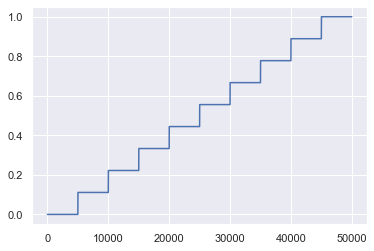

In [291]:
plt.plot(X['gamma'])

In [194]:
explainer.eval_explainer()

0it [00:00, ?it/s]

IndexError: list index out of range

In [205]:
expleener = shap.KernelExplainer(true_model.predict, shap.sample(X2, 100))

In [209]:
shap_vals = expleener.shap_values(X2[:100,:])

  0%|          | 0/100 [00:00<?, ?it/s]

In [212]:
def choose_data(feature, i, X):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        tol = 0.1
        num_vals = 100
        where__ = np.ones_like(X[feature].values, dtype=bool)
        
        for j in range(1,3):
            where__ = np.multiply(where__, np.abs(X.values[:,(i + j)%3])<tol)
        data_arr = X.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([data_arr.shape[0]]), replace=False))]
        return data_arr 

In [217]:
X2

array([[1.0626333 , 0.33885701, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.0626333 , 0.33885701, 0.00400802, ..., 0.        , 0.        ,
        0.        ],
       [1.0626333 , 0.33885701, 0.00801603, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.36023036, 0.        , 1.99198397, ..., 0.        , 0.        ,
        0.        ],
       [0.36023036, 0.        , 1.99599198, ..., 0.        , 0.        ,
        0.        ],
       [0.36023036, 0.        , 2.        , ..., 0.        , 0.        ,
        0.        ]])

In [216]:
explainer_type = 'shap'
first_run = True
for i, __feature in enumerate(X2.columns):
    if __feature in ['x0','v0''t']:
        arr = choose_data(__feature, i, X2)
    else:
        arr = X.iloc[np.sort(np.random.choice(X2.shape[0], 100, replace=False))]
    if explainer_type=='shap':
        __atts = expleener.shap_values(arr)
    if explainer_type=='lime':
        __atts = self.explainers[__explainer].attributions(arr)
    if explainer_type=='analytic':
        __atts = self.explainers[__explainer].feature_att(arr)

    for j, __contribution in enumerate(y.columns):
                        multi_index = [range(len(shap_vals)), [__feature for i in range(len(shap_vals))], 
                                       [__contribution for i in range(len(shap_vals))],
                                       [__explainer for i in range(len(shap_vals))]]
                        if first_run:
                            shap_vals_arr = pd.DataFrame(shap_vals[j], 
                                                                     columns = y.columns, 
                                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                            names=('num', 'feature', 'contribution', 'model')))
                            first_run = False
                        else:
                            shap_vals_arr = shap_vals_arr.append(pd.DataFrame(shap_vals[j], 
                                                                     columns = self.test_data.columns, 
                                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                            names=('num', 'feature', 'contribution', 'model'))))


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [207]:
true_model.predict(X2[:100,:])

array([[ 0.13164111, -0.66402649],
       [ 0.00819183, -0.5773278 ],
       [-0.10063379, -0.51773135],
       [-0.20035837, -0.48625573],
       [-0.29665373, -0.48341944],
       [-0.39524091, -0.50911872],
       [-0.50169759, -0.56183409],
       [-0.62103914, -0.6371351 ],
       [-0.7569193 , -0.7253462 ],
       [-0.91028478, -0.80847995],
       [-1.07742412, -0.85757127],
       [-1.24777744, -0.83372384],
       [-1.40277803, -0.69835283],
       [-1.51795915, -0.43534612],
       [-1.56995246, -0.07461485],
       [-1.5462739 ,  0.30783834],
       [-1.45145499,  0.62557809],
       [-1.3044289 ,  0.82663003],
       [-1.12939853,  0.90958734],
       [-0.94703046,  0.90698002],
       [-0.77026395,  0.86002613],
       [-0.60435271,  0.80298558],
       [-0.44882988,  0.7588842 ],
       [-0.29963192,  0.74124175],
       [-0.15067998,  0.75723536],
       [ 0.00511746,  0.81012444],
       [ 0.17519805,  0.90009806],
       [ 0.36664059,  1.02291683],
       [ 0.58489307,

In [208]:
y

,xt,vt
0,0.131641,-0.664026
1,0.019845,-0.464576
2,-0.057970,-0.321950
3,-0.111922,-0.224242
4,-0.150076,-0.162749
...,...,...
49995,-1.005353,0.328753
49996,-0.940287,0.319536
49997,-0.878343,0.298207
49998,-0.821587,0.268096


In [ ]:
def exp_plot(X, y, atts):
        """
            Plotting routine to visualise the explainers' results. Plots individual
            feature contribution for each model and each feature.
        """
        f, axs = plt.subplots(y.test_labels.shape[1], X.test_data.shape[1], 
                              figsize=(4*X.test_data.shape[1], 8), 
                              gridspec_kw=dict(width_ratios=4*np.ones((X.test_data.shape[1]))))

        for i, __feature in enumerate(X.test_data.columns):
            for j, __contribution in enumerate(y.test_labels.columns):
                sns.scatterplot(data = atts.xs((__feature, __contribution), 
                                                  level=('feature', 'contribution', 'model')), 
                                x = atts.xs((__feature, __contribution, 'true'), 
                                               level=('feature', 'contribution', 'model')).index,
                                y = atts.xs((__feature, __contribution), 
                                             level=('feature', 'contribution', 'model'))[__feature],
                                label = '__model', ax=axs[j,i])  
                    
                axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
                axs[j,i].set_xlabel('Index [ ]')
                axs[j,i].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()

        #f.savefig("Images/"+self.explainer_type+"_summary"+self.suffix+"_kernel_good.svg", dpi='figure')